#### Business Context:
- Term deposits are very valuable for banks, because they are locked-in long-term deposits. Banks need customers to deposit money in order to be able to give out loans, so the more deposits they can lock in, the better. Term deposits are typically NOT linked to market performance, and typically have a fixed interest rate over the locked-in period (e.g., 12 months, 30 days, etc.). As such, they're safe, but not very profitable investments. Generally they are good investments for retirees (or people close to retirement), or people looking to earn some interest on their savings without losing money (e.g., people saving for an education, or for a house downpayment). 
- Since the target market is very specific for this type of product, and it's very profitable for the bank, you would want to maximize the potential of customers who would say YES and agree to invest their money. For this reason we prioritize Recall as a metric for our models.

#### Data Cleaning:
- No missing values; no need to impute
- 4 columns have "Unknown" values: Job, Education, Contact and Poutcome
    - Poutcome refers to the outcome of prior marketing call; "unknown" here is a meaningful value, likely meaning the customer didn't answer the phone
    - For Job and Education, we can leave as is. Not many values are missing
    - For Contact, across numerical columns it appears that the "Unknown" category behaves closer to the "Cellular" category (i.e., Unknown customers have same avg age as Cellular customers). Therefore, let's assume unknowns are cellular

#### Data Exploration Summary:
- Students and Retired customers respond with "YES". This makes sense, because Term products are secure investments so customers with low tolerance for market risk would be more likely to take advantage of these financial vehicles.
- Single people have a slightly higher likelihood of responding positively
- People with no defaults, no housing, and no loans are more likely to respond. Again this makes sense, since Term deposits are safe investments. Perhaps those saving for a home would benefit from them.
- Customers with tertiary education seem slightly more likely to respond positively
- Customers targeted in October, March and December, and in campaigns 1-5 and 32 seem more likely to respond positively
- Customers who responded positively in previous campaigns are more likely to respon positively (i.e., if they invested in Term products before they are likely to re-invest)
- Higher ages, higher phone call lengths, higher number of days since last contact are all linked to higher likelihood to respond


#### Data Preparation for Modelling
- Split data in train/test
- Resample Training data for Logistic Regression and KNN 
- Apply pipeline to One Hot Encode categorical variables, and standard scaling for numerical

#### Baseline Models
- Tune hyperparameters and find best estimators for both models
- Prioritize Recall; since Term deposits are good for the bank, we want to have broad reach for as many potential customers as possible. It's better to prioritize reaching MORE people, even if they say no. If we prioritized precision, we will miss some potential customers who would have said yes.


#### Basline Model Performance
- Logistic Regression Recall is 0.78, while KNN is 0.66. Training time for KNN is much lower, but both models are less than 1 second. Both of these would be good choices to implement from a computation perspective. We will evaluate if ensembles can achieve greater recall

#### Ensemble Model Performance and Explanation
- We can see that despite optimizing for Recall, Random Forest and AdaBoost both performed much better on Precision than Recall. Let's discuss why that is:
    - Random Forest: 
        - the RF model creates many decision trees built on a subset of samples, and subset of features. When dealing with imbalanced datasets, it is more likely to perform well on the majority class, as each tree has a lower likelihood of capturing a meaningful number of observations of the minority class. Because of this, it is likely going to become less sensitive to the positive class and therefore, would have lower recall (i.e, not able to recognize many of the positive class instances). Additionally, the model averages predictions across many decision trees, which makes the model more conservative. This means it will make fewer positive predictions, leading to fewer false positives (i.e., higher precision), but also fewer true positives (i.e., lower recall). 
        - When reviewing feature importances, we see Duration at the top. This aligns with our exploratory analysis. However, we also see Balance at the top. This does NOT align with our exploratory analysis. Random Forest models use random selection of features in each tree, and just because a feature comes up frequently, doesn't mean that it's a good predictor of the outcome. It's possible that Balance was selected frequently in combination with other features by each tree in the forest, when trying to achieve pure nodes (as this is the objective of decision trees). 
        - We note that poutcome is NOT a feature that is frequently used by the RF model (even though) this is arguably the best predictor of success. Since feature selection for each tree is random, we can never guarantee that strongly correlated features will be selected. It's also likely that this feature doesn't combine well with others to produce more pure nodes, thus the model deprioritized this feature in the selection process. Both of these reasons will lead to lower recall.
    - Ada Boost:
        - The AdaBoost model has two algorithm options - SAMME and SAMME.R. SAMME will place equal weights on all weak learners, but we want to use SAMME.R in order for better learners to have higher weightts. In the grid search function, I'm testing learning rates 0.1 and 0.01 - I'm NOT including 1, as this could lead to all learners having the same weight. I'm also testing up to 500 learners to give the model lots of opportunity to learn the data set, since we have an imbalanced data set.
        -  We see a few things in the AdaBoost model: Duration has the highest feature importance, followed by age and pdays. We also see that poutcome_success has higher importance in this model vs. the RF model.
        - We see that the weights of each weak learner is 1, despite using SAMME.R. This can happen for a few reasons - many learners are likely using the same feature (duration), since it has the largest importance. When printing the predictions of the weak learners, we see that they are similar. The error rates of each learner are similar as they progress. For these reasons, the model will keep the weights uniform. When the weights of the model are uniform, the predictions are simply averaged rather than weighed - this will result in higher precision and lower recall (as we see in the performance). To combat this issue, we would need to introduce more variability in the data and better features which have stronger relationships with the output category. 
    - The Voting and Bagging classifiers, which both use non-ensemble models performed predictably better on recall than precision, however worse than the Logistic Regression by itself and the KNN model by itself. The Bagging Classifier uses decision trees as its base model. We can see that Duration was the most important feature for this model as well. We don't see much strong relationships between other features. Decision trees don't handle data imbalance well so we would expect precision to be lower than recall.
    - The Voting classifier performance is an average of Logistic Regression, KNN and Decision Trees so it makes sense for recall to be higher.

#### Business Impact
- In terms of implementation, every day there likely would be customers whose term investements are coming due and should be re-invested, and potentially customers who have a high balance that could be invested in a term deposit. The best strategy for the bank is to call customers DAILY to try to get them to invest their money in a term deposit. 
- The ensemble models take a very long time to run, as opposed to the simpler models, and the recall isn't great. Therefore, based on performance, a simple Logistic Regression would be a good solution here. It would run daily to identify customers to contact. This list could be given to the call center. Customers could be prioritized based on whether they are renewing the term deposit or potentially depositing new dollars. 

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import time

In [43]:
# supress warnings
import warnings
warnings.filterwarnings("ignore")

### Data Cleaning

In [6]:
df = pd.read_csv('/Users/delinaivanova/Downloads/archive/train.csv', sep=';')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [9]:
# Check number of unknowns
df.isin(['unknown']).sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

In [12]:
# Assess if relationship exists between other variables and Contact to inform imputation strategy
df.groupby('contact').describe().T

contact              cellular     telephone       unknown
age      count   29285.000000   2906.000000  13020.000000
         mean       40.400785     47.837922     40.600077
         std        10.494896     13.934969      9.439221
         min        18.000000     18.000000     20.000000
         25%        32.000000     37.000000     33.000000
         50%        38.000000     47.000000     39.000000
         75%        48.000000     57.000000     48.000000
         max        94.000000     95.000000     61.000000
balance  count   29285.000000   2906.000000  13020.000000
         mean     1397.926993   1803.704061   1183.550384
         std      3057.197381   4301.802924   2638.647690
         min     -8019.000000  -1965.000000  -3372.000000
         25%        79.000000    124.000000     50.000000
         50%       463.000000    657.000000    389.000000
         75%      1468.000000   1987.000000   1255.250000
         max    102127.000000  98417.000000  58544.000000
day      count   29285.000000   2906.000000  13020.000000
         mean       15.930306     16.557467     15.360138
         std         8.210676      8.742893      8.454077
         min         1.000000      1.000000      1.000000
         25%         9.000000      9.000000      8.000000
         50%        16.000000     17.000000     15.000000
         75%        21.000000     23.000000     21.000000
         max        31.000000     31.000000     31.000000
duration count   29285.000000   2906.000000  13020.000000
         mean      263.013966    235.366139    252.340476
         std       253.501587    290.118299    258.405545
         min         0.000000      2.000000      0.000000
         25%       106.000000     75.000000    101.000000
         50%       184.000000    155.000000    178.000000
         75%       326.000000    282.000000    311.000000
         max      3422.000000   4918.000000   3881.000000
campaign count   29285.000000   2906.000000  13020.000000
         mean        2.690114      3.400895      2.787481
         std         2.900720      3.623406      3.371954
         min         1.000000      1.000000      1.000000
         25%         1.000000      1.000000      1.000000
         50%         2.000000      2.000000      2.000000
         75%         3.000000      4.000000      3.000000
         max        50.000000     43.000000     63.000000
pdays    count   29285.000000   2906.000000  13020.000000
         mean       56.885129     46.312801      1.299386
         std       113.379313    104.231149     36.451647
         min        -1.000000     -1.000000     -1.000000
         25%        -1.000000     -1.000000     -1.000000
         50%        -1.000000     -1.000000     -1.000000
         75%        51.000000     -1.000000     -1.000000
         max       871.000000    690.000000    850.000000
previous count   29285.000000   2906.000000  13020.000000
         mean        0.804064      0.827254      0.021966
         std         2.695072      2.501998      0.502526
         min         0.000000      0.000000      0.000000
         25%         0.000000      0.000000      0.000000
         50%         0.000000      0.000000      0.000000
         75%         1.000000      0.000000      0.000000
         max       275.000000     37.000000     41.000000

In [13]:
# Replace Unknown in contact column with "cellular"
df['contact'] = df['contact'].replace('unknown','cellular')

In [14]:
# validate change
df.isin(['unknown']).sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact          0
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

### Data Exploration

In [16]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [17]:
cat_columns = ['job', 'marital', 'education', 'default','housing',
       'loan', 'contact','month','campaign','poutcome']
num_columns = ['age','balance','day','duration','pdays','previous']

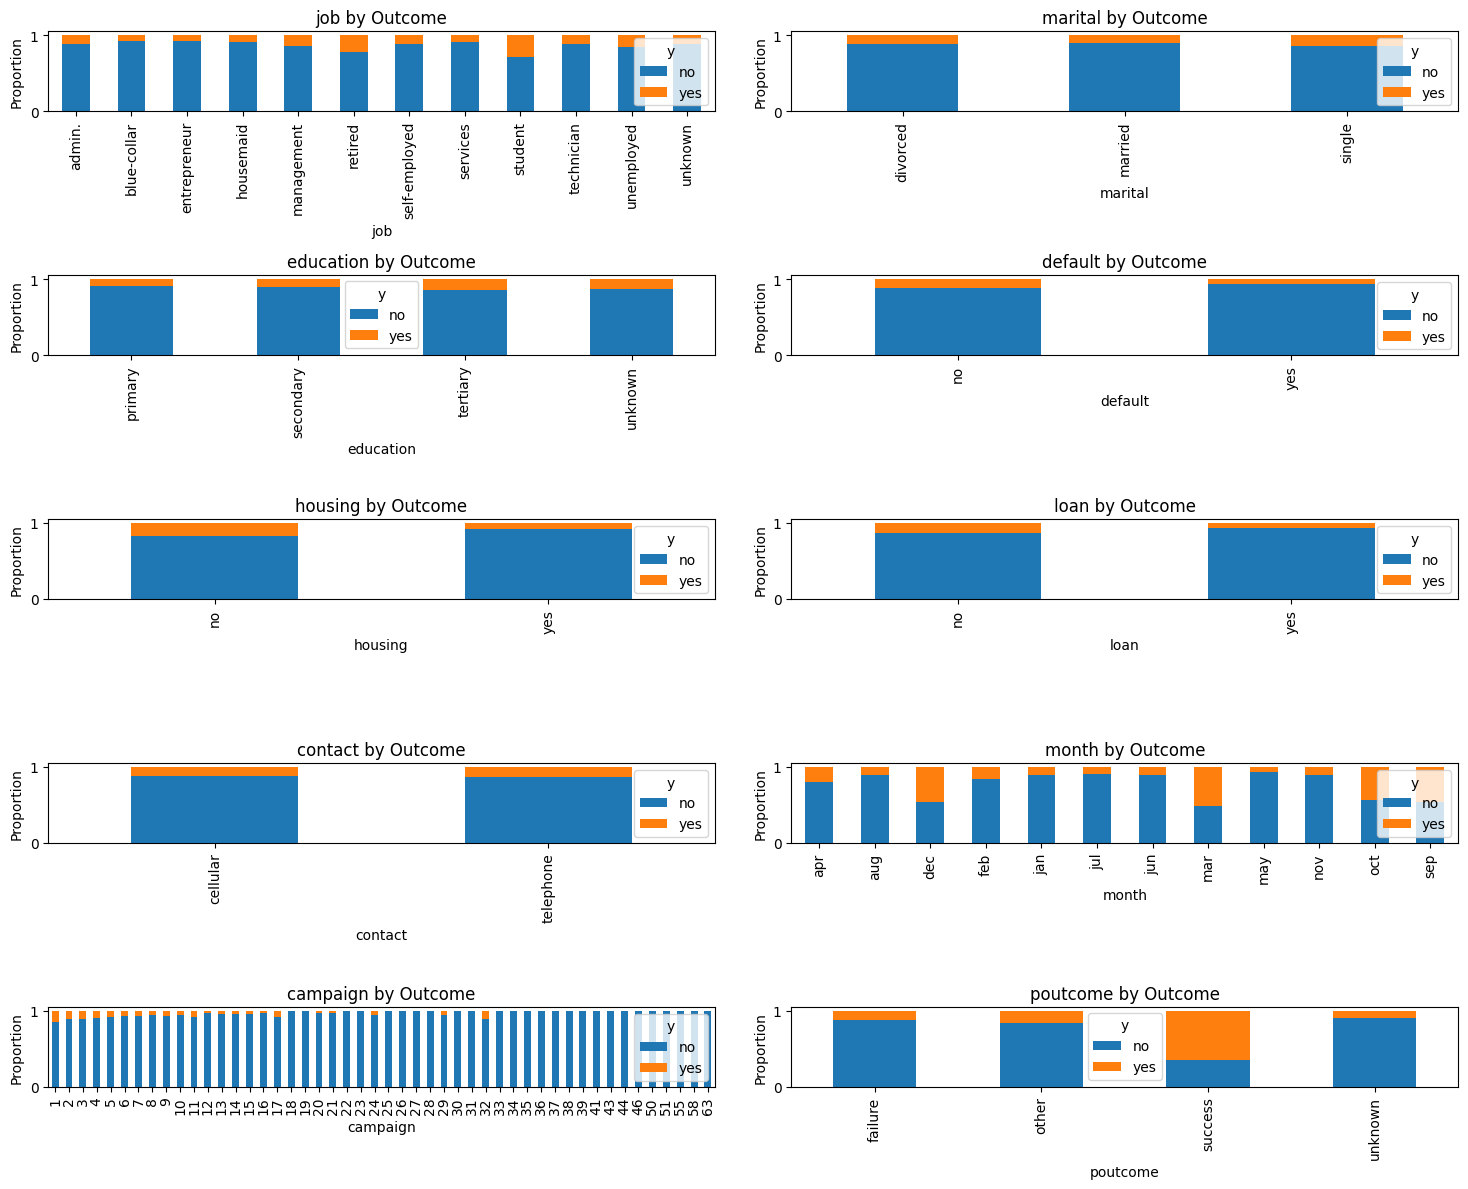

In [20]:
# Create a figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over the categorical columns and create stacked bar charts
for i, col in enumerate(cat_columns):
    # Group by the categorical column and the target variable 'y', normalize to get percentages
    grouped = df.groupby([col, 'y']).size().unstack().fillna(0)
    grouped_norm = grouped.div(grouped.sum(axis=1), axis=0)
    
    # Plot the stacked bar chart on the respective subplot
    grouped_norm.plot(kind='bar', stacked=True, ax=axes[i])
    
    # Add labels and title
    axes[i].set_title(f'{col} by Outcome')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Proportion')

# Remove any unused subplots (in case of more subplots than needed)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

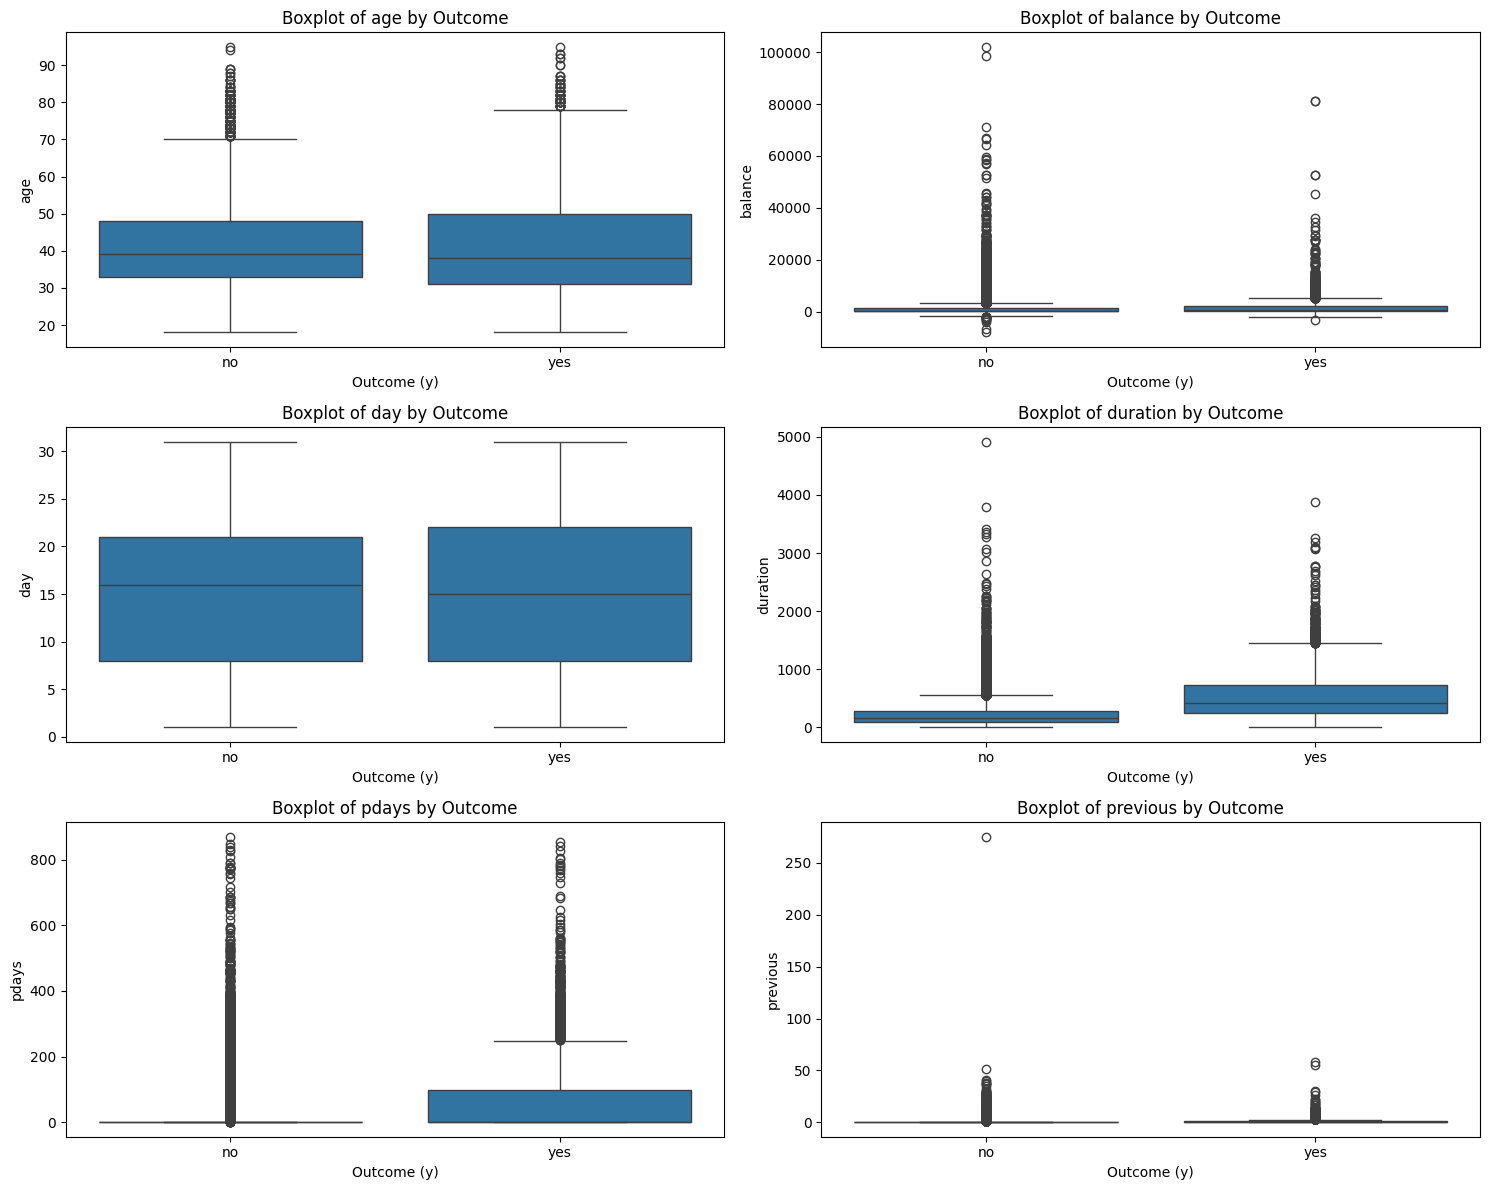

In [24]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over the continuous columns and create boxplots by 'y' outcome
for i, col in enumerate(num_columns):
    # Create a boxplot for each continuous variable grouped by the target variable 'y'
    sns.boxplot(x='y', y=col, data=df, ax=axes[i])
    
    # Add labels and title
    axes[i].set_title(f'Boxplot of {col} by Outcome')
    axes[i].set_xlabel('Outcome (y)')
    axes[i].set_ylabel(col)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Model Building - Baseline Models

In [25]:
# Replace output variable with 1/0
df['y'] = df['y'].map({'yes':1, 'no':0})

In [34]:
# Define the categorical and numerical columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 
                       'loan', 'contact', 'month', 'poutcome']
numerical_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),     # Apply StandardScaler to numerical columns
        ('cat', OneHotEncoder(drop='first'), categorical_columns)  # Apply OneHotEncoder to categorical columns
    ])

# Applying transformation to the data
X = df.drop('y', axis=1)  # Features (drop the target column 'y')
y = df['y']  # Target variable (encoding 'y' to binary)

# Fit and transform the data
X_transformed = preprocessor.fit_transform(X)

# Convert the transformed data to dense format (if sparse)
X_transformed_dense = X_transformed.toarray() if hasattr(X_transformed, 'toarray') else X_transformed

# Get the column names for the One-Hot Encoded features
ohe_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)

# Combine numerical and encoded categorical feature names
all_columns = numerical_columns + list(ohe_columns)

# Create a DataFrame with transformed data and appropriate column names
X_transformed_df = pd.DataFrame(X_transformed_dense, columns=all_columns)

# Display the transformed data
X_transformed_df.head()



,age,balance,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0.256419,0.011016,-0.569351,-0.411453,-0.25194,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.288529,-0.437895,-0.416127,-0.569351,-0.411453,-0.25194,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.747384,-0.446762,-0.707361,-0.569351,-0.411453,-0.25194,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.571051,0.047205,-0.645231,-0.569351,-0.411453,-0.25194,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.747384,-0.447091,-0.233620,-0.569351,-0.411453,-0.25194,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Best Logistic Regression Model:
{'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.97      0.85      0.90     11966
           1       0.41      0.78      0.53      1598

    accuracy                           0.84     13564
   macro avg       0.69      0.81      0.72     13564
weighted avg       0.90      0.84      0.86     13564

Accuracy: 0.8395753465054556
ROC AUC: 0.8992619263131229

Best k-NN Model:
{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     11966
           1       0.40      0.66      0.49      1598

    accuracy                           0.84     13564
   macro avg       0.67      0.76      0.70     13564
weighted avg       0.88      0.84      0.86     13564

Accuracy: 0.841197286936007
ROC AUC: 0.8076371789322981


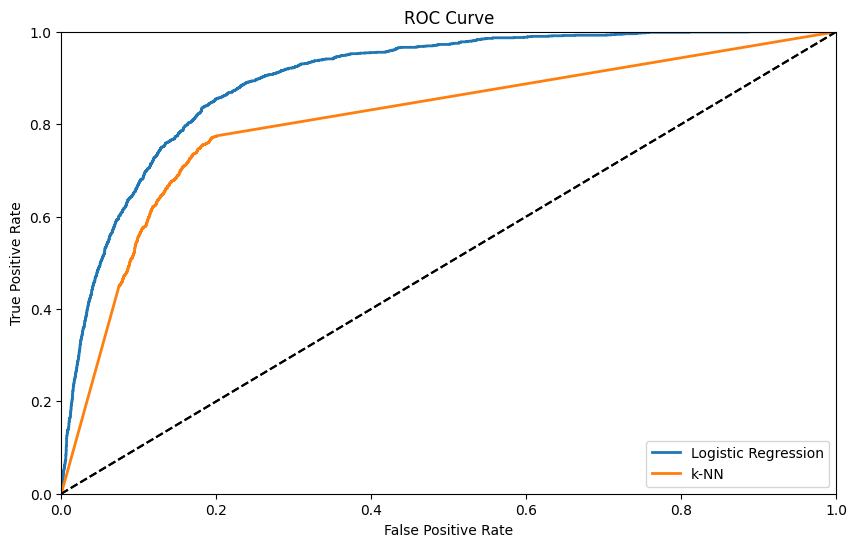

In [40]:
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_transformed_dense, y, test_size=0.3, random_state=42)

# Apply SMOTE only on the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Hyperparameter tuning for Logistic Regression
log_reg_params = {
    'C': [0.1, 1, 10],              # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Solver options
    'max_iter': [100, 200]           # Number of iterations
}

log_reg = LogisticRegression()
grid_search_log_reg = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='recall')
grid_search_log_reg.fit(X_train_resampled, y_train_resampled)

# Get the best Logistic Regression model
best_log_reg = grid_search_log_reg.best_estimator_

# Hyperparameter tuning for k-NN
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 50, 100, 1000],   # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, knn_params, cv=5, scoring='recall')
grid_search_knn.fit(X_train_resampled, y_train_resampled)

# Get the best k-NN model
best_knn = grid_search_knn.best_estimator_

# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

# Predictions and probabilities for Logistic Regression
y_pred_log = best_log_reg.predict(X_test)
y_pred_log_prob = best_log_reg.predict_proba(X_test)[:, 1]

# Predictions and probabilities for k-NN
y_pred_knn = best_knn.predict(X_test)
y_pred_knn_prob = best_knn.predict_proba(X_test)[:, 1]

# Print performance metrics for both models
print("Best Logistic Regression Model:")
print(grid_search_log_reg.best_params_)
print(classification_report(y_test, y_pred_log))
print(f"Accuracy: {accuracy_score(y_test, y_pred_log)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_log_prob)}")

print("\nBest k-NN Model:")
print(grid_search_knn.best_params_)
print(classification_report(y_test, y_pred_knn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_knn_prob)}")

# ROC Curve for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_log_prob)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn_prob)

# Plot the ROC curve for both models
plt.figure(figsize=(10, 6))
plot_roc_curve(fpr_log, tpr_log, label="Logistic Regression")
plot_roc_curve(fpr_knn, tpr_knn, label="k-NN")
plt.legend(loc="lower right")
plt.show()

In [41]:
# Print training times

# Measuring the training time for the best Logistic Regression and k-NN models

# Measure training time for Logistic Regression
start_time_log_train = time.time()
best_log_reg.fit(X_train_resampled, y_train_resampled)  # Train the best Logistic Regression model
end_time_log_train = time.time()
log_reg_training_time = end_time_log_train - start_time_log_train

# Measure training time for k-NN
start_time_knn_train = time.time()
best_knn.fit(X_train_resampled, y_train_resampled)  # Train the best k-NN model
end_time_knn_train = time.time()
knn_training_time = end_time_knn_train - start_time_knn_train

# Print the training time for both models
print(f"Training time for Logistic Regression (best params): {log_reg_training_time:.4f} seconds")
print(f"Training time for k-NN (best params): {knn_training_time:.4f} seconds")


Training time for Logistic Regression (best params): 0.1428 seconds
Training time for k-NN (best params): 0.0017 seconds


### Ensemble Models


Random Forest Performance:
Training time: 208.3314 seconds
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     11966
           1       0.66      0.40      0.50      1598

    accuracy                           0.91     13564
   macro avg       0.79      0.69      0.72     13564
weighted avg       0.89      0.91      0.89     13564

Accuracy: 0.9054113830728399
ROC AUC: 0.9102195477925878

AdaBoost Performance:
Training time: 116.3101 seconds
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.62      0.33      0.43      1598

    accuracy                           0.90     13564
   macro avg       0.77      0.65      0.69     13564
weighted avg       0.88      0.90      0.88     13564

Accuracy: 0.8972279563550575
ROC AUC: 0.9063026823810558

Bagging Classifier Performance:
Training time: 1438.4915 seconds
              precision    recall  f1-score   suppo

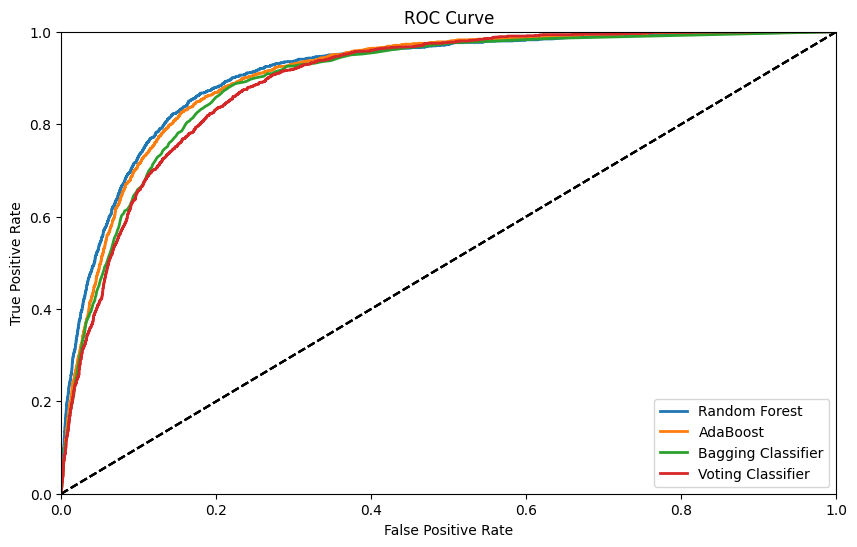

In [69]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

# 1. Training Random Forest and AdaBoost on original data (without resampling)
# ---------------------------------------------------------------------------

# Random Forest (no resampling)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, rf_params, cv=5, scoring='recall')
start_time_rf_train = time.time()
grid_search_rf.fit(X_train, y_train)
end_time_rf_train = time.time()
best_rf = grid_search_rf.best_estimator_
rf_training_time = end_time_rf_train - start_time_rf_train

# AdaBoost (no resampling)
ada_params = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.1]
}

ada = AdaBoostClassifier(random_state=42, algorithm='SAMME.R')
grid_search_ada = GridSearchCV(ada, ada_params, cv=5, scoring='recall')
start_time_ada_train = time.time()
grid_search_ada.fit(X_train, y_train)
end_time_ada_train = time.time()
best_ada = grid_search_ada.best_estimator_
ada_training_time = end_time_ada_train - start_time_ada_train

# 2. Training Bagging Classifier and Voting Classifier on resampled data
# ----------------------------------------------------------------------

# Bagging Classifier (with resampling)
bagging_params = {
    'n_estimators': [50, 100, 200],
    'estimator': [DecisionTreeClassifier(), None],
    'max_samples': [0.5, 0.75, 1.0]
}

bagging = BaggingClassifier(random_state=42)
grid_search_bagging = GridSearchCV(bagging, bagging_params, cv=5, scoring='recall')
start_time_bagging_train = time.time()
grid_search_bagging.fit(X_train_resampled, y_train_resampled)
end_time_bagging_train = time.time()
best_bagging = grid_search_bagging.best_estimator_
bagging_training_time = end_time_bagging_train - start_time_bagging_train

# Voting Classifier (with resampling, using knn, lr, and decision tree)
voting_clf = VotingClassifier(estimators=[
    ('knn', best_knn),
    ('lr', best_log_reg),
    ('dt', DecisionTreeClassifier())
], voting='soft')

start_time_voting_train = time.time()
voting_clf.fit(X_train_resampled, y_train_resampled)
end_time_voting_train = time.time()
voting_training_time = end_time_voting_train - start_time_voting_train

# 3. Evaluating and printing the performance of each ensemble model
# ------------------------------------------------------------------

# Performance evaluation for each model

# Random Forest
y_pred_rf = best_rf.predict(X_test)
y_pred_rf_prob = best_rf.predict_proba(X_test)[:, 1]

# AdaBoost
y_pred_ada = best_ada.predict(X_test)
y_pred_ada_prob = best_ada.predict_proba(X_test)[:, 1]

# Bagging Classifier
y_pred_bagging = best_bagging.predict(X_test)
y_pred_bagging_prob = best_bagging.predict_proba(X_test)[:, 1]

# Voting Classifier
y_pred_voting = voting_clf.predict(X_test)
y_pred_voting_prob = voting_clf.predict_proba(X_test)[:, 1]

# Print performance metrics and training time for each model

def print_model_performance(model_name, y_test, y_pred, y_pred_prob, training_time):
    print(f"\n{model_name} Performance:")
    print(f"Training time: {training_time:.4f} seconds")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob)}")

print_model_performance("Random Forest", y_test, y_pred_rf, y_pred_rf_prob, rf_training_time)
print_model_performance("AdaBoost", y_test, y_pred_ada, y_pred_ada_prob, ada_training_time)
print_model_performance("Bagging Classifier", y_test, y_pred_bagging, y_pred_bagging_prob, bagging_training_time)
print_model_performance("Voting Classifier", y_test, y_pred_voting, y_pred_voting_prob, voting_training_time)

# 4. Plot ROC Curves for all models
# ---------------------------------
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_pred_ada_prob)
fpr_bagging, tpr_bagging, _ = roc_curve(y_test, y_pred_bagging_prob)
fpr_voting, tpr_voting, _ = roc_curve(y_test, y_pred_voting_prob)

plt.figure(figsize=(10, 6))
plot_roc_curve(fpr_rf, tpr_rf, label="Random Forest")
plot_roc_curve(fpr_ada, tpr_ada, label="AdaBoost")
plot_roc_curve(fpr_bagging, tpr_bagging, label="Bagging Classifier")
plot_roc_curve(fpr_voting, tpr_voting, label="Voting Classifier")
plt.legend(loc="lower right")
plt.show()


Number of features used in Random Forest: 40
Number of feature names provided: 40
Feature indices in the trees: [24, 35, 23, 3, 38, 1, 39, 5, 2, 6, 26, 28, 0, 31, 10, 34, 29, 20, 17, 22, 13, 30, 8, 33, 21, 11, 18, 19, 12, 25, 9, 15, 7, 32, 4, 37, 36, 16, 14, 27]
Highest feature index in the model: 39
                Feature  Usage Count
2              duration        32570
1               balance        30319
0                   age        28482
3              campaign        17807
19  education_secondary         7975
4                 pdays         7480
14       job_technician         6967
9        job_management         6687
24             loan_yes         6434
17      marital_married         6297
20   education_tertiary         6024
5              previous         5415
18       marital_single         5403
6       job_blue-collar         5189
31            month_jun         5094
25    contact_telephone         5052
23          housing_yes         5036
30            month_jul         

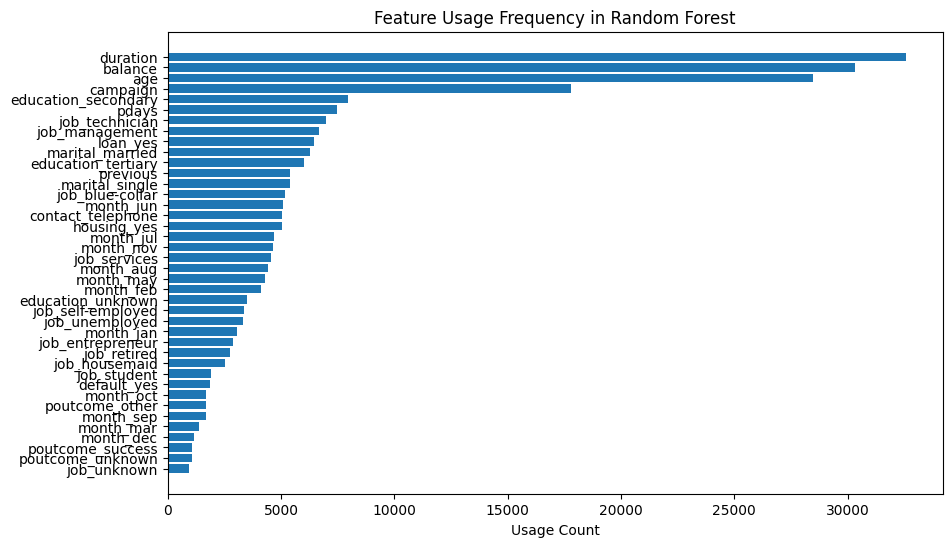

In [62]:
from collections import Counter

# 5. Feature Usage Frequency in Random Forest
# -------------------------------------------

# Get all individual decision trees from the Random Forest
estimators = best_rf.estimators_

# Initialize a counter to keep track of feature usage
feature_usage_counter = Counter()

# Assuming 'feature_names' has been defined or obtained from the data processing pipeline:
# Replace this with the correct list of feature names:
feature_names = X_transformed_df.columns.tolist()  # Make sure this is from the processed data, not raw data.

# Check that the length of feature_names matches the number of features used by the model
print(f"Number of features used in Random Forest: {best_rf.n_features_in_}")
print(f"Number of feature names provided: {len(feature_names)}")

# Debugging step: Print the feature usage indices in the trees
for tree in estimators:
    feature_indices = tree.tree_.feature
    feature_usage_counter.update(feature_indices[feature_indices >= 0])  # Ignore leaves (-2)

# Print feature indices in the trees to debug the range of indices
print(f"Feature indices in the trees: {list(feature_usage_counter.keys())}")
print(f"Highest feature index in the model: {max(feature_usage_counter.keys())}")

# Ensure that feature indices are valid with respect to feature_names
# Handle potential IndexError
try:
    # Create a dictionary mapping feature names to usage counts
    feature_usage_count = {feature_names[i]: count for i, count in feature_usage_counter.items() if i < len(feature_names)}
except IndexError as e:
    print(f"Error: {e}. Some feature indices exceed the number of feature names.")
    raise

# Create a DataFrame for better visualization
feature_usage_df = pd.DataFrame({
    'Feature': feature_names,
    'Usage Count': [feature_usage_count.get(f, 0) for f in feature_names]  # Get count, default to 0 if not used
})

# Sort by usage count
feature_usage_df = feature_usage_df.sort_values(by='Usage Count', ascending=False)

# Display the feature usage frequency
print(feature_usage_df)

# Plotting the feature usage frequency (optional)
plt.figure(figsize=(10, 6))
plt.barh(feature_usage_df['Feature'], feature_usage_df['Usage Count'])
plt.gca().invert_yaxis()  # Invert y-axis to show the most frequently used feature at the top
plt.title('Feature Usage Frequency in Random Forest')
plt.xlabel('Usage Count')
plt.show()

#### AdaBoost Analysis

                Feature  Importance
2              duration       0.224
0                   age       0.084
4                 pdays       0.078
33            month_may       0.066
1               balance       0.050
3              campaign       0.050
30            month_jul       0.050
34            month_nov       0.036
26            month_aug       0.036
38     poutcome_success       0.034
29            month_jan       0.034
31            month_jun       0.030
32            month_mar       0.028
23          housing_yes       0.028
24             loan_yes       0.022
20   education_tertiary       0.022
5              previous       0.020
35            month_oct       0.020
17      marital_married       0.018
36            month_sep       0.016
6       job_blue-collar       0.016
28            month_feb       0.008
27            month_dec       0.008
13          job_student       0.006
18       marital_single       0.004
37       poutcome_other       0.004
7      job_entrepreneur     

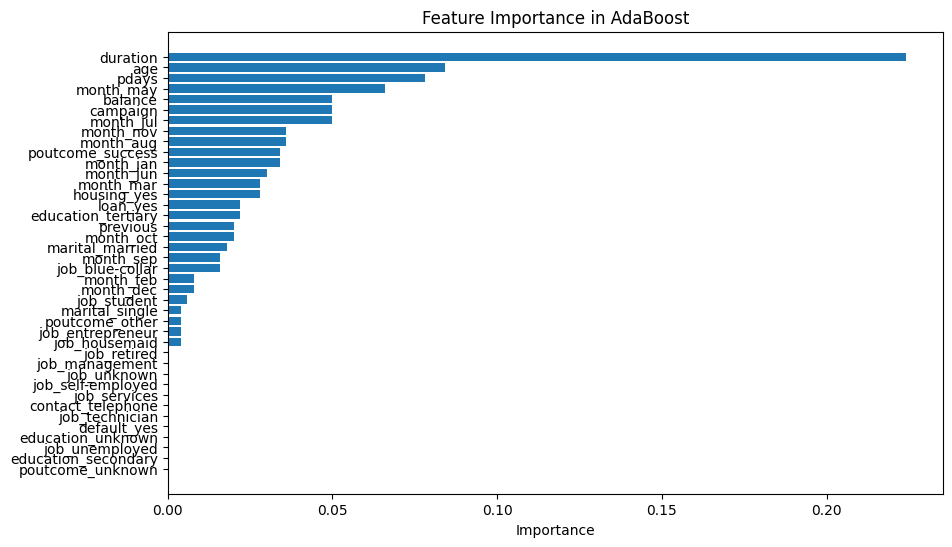

In [70]:
# Feature importance in AdaBoost
feature_importances = best_ada.feature_importances_

# Assuming you have the correct feature names defined
feature_importance_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Optional: Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance in AdaBoost')
plt.xlabel('Importance')
plt.show()


In [71]:
# Number of weak learners (estimators)
n_estimators = len(best_ada.estimators_)
print(f"Number of weak learners: {n_estimators}")

# Error rate of each weak learner
estimator_errors = best_ada.estimator_errors_  # AdaBoost error rate for each weak learner
print("Error rates for weak learners:")
for idx, error in enumerate(estimator_errors):
    print(f"Weak learner {idx+1} error rate: {error:.4f}")


Number of weak learners: 500
Error rates for weak learners:
Weak learner 1 error rate: 0.1166
Weak learner 2 error rate: 0.1383
Weak learner 3 error rate: 0.1411
Weak learner 4 error rate: 0.1834
Weak learner 5 error rate: 0.2064
Weak learner 6 error rate: 0.2010
Weak learner 7 error rate: 0.2506
Weak learner 8 error rate: 0.2715
Weak learner 9 error rate: 0.2917
Weak learner 10 error rate: 0.2746
Weak learner 11 error rate: 0.2856
Weak learner 12 error rate: 0.3426
Weak learner 13 error rate: 0.3582
Weak learner 14 error rate: 0.3295
Weak learner 15 error rate: 0.3351
Weak learner 16 error rate: 0.3849
Weak learner 17 error rate: 0.4051
Weak learner 18 error rate: 0.4149
Weak learner 19 error rate: 0.3682
Weak learner 20 error rate: 0.3919
Weak learner 21 error rate: 0.3904
Weak learner 22 error rate: 0.3859
Weak learner 23 error rate: 0.4491
Weak learner 24 error rate: 0.4004
Weak learner 25 error rate: 0.3935
Weak learner 26 error rate: 0.3998
Weak learner 27 error rate: 0.4667
Weak

In [72]:
# Weights of each weak learner
estimator_weights = best_ada.estimator_weights_  # The weight of each weak learner in the final model
print("Weights of weak learners:")
for idx, weight in enumerate(estimator_weights):
    print(f"Weak learner {idx+1} weight: {weight:.4f}")


Weights of weak learners:
Weak learner 1 weight: 1.0000
Weak learner 2 weight: 1.0000
Weak learner 3 weight: 1.0000
Weak learner 4 weight: 1.0000
Weak learner 5 weight: 1.0000
Weak learner 6 weight: 1.0000
Weak learner 7 weight: 1.0000
Weak learner 8 weight: 1.0000
Weak learner 9 weight: 1.0000
Weak learner 10 weight: 1.0000
Weak learner 11 weight: 1.0000
Weak learner 12 weight: 1.0000
Weak learner 13 weight: 1.0000
Weak learner 14 weight: 1.0000
Weak learner 15 weight: 1.0000
Weak learner 16 weight: 1.0000
Weak learner 17 weight: 1.0000
Weak learner 18 weight: 1.0000
Weak learner 19 weight: 1.0000
Weak learner 20 weight: 1.0000
Weak learner 21 weight: 1.0000
Weak learner 22 weight: 1.0000
Weak learner 23 weight: 1.0000
Weak learner 24 weight: 1.0000
Weak learner 25 weight: 1.0000
Weak learner 26 weight: 1.0000
Weak learner 27 weight: 1.0000
Weak learner 28 weight: 1.0000
Weak learner 29 weight: 1.0000
Weak learner 30 weight: 1.0000
Weak learner 31 weight: 1.0000
Weak learner 32 weight

In [73]:
# Get predictions from each weak learner
weak_learner_predictions = np.array([est.predict(X_test) for est in best_ada.estimators_])

# Convert weak learner predictions to weighted predictions
weighted_learner_predictions = np.array([
    estimator_weights[i] * weak_learner_predictions[i] for i in range(n_estimators)
])

# Final prediction: Weighted majority vote of weak learners
final_predictions = np.sign(np.sum(weighted_learner_predictions, axis=0))

# Check how the final prediction compares to each individual weak learner
for idx in range(n_estimators):
    agreement = np.mean(weak_learner_predictions[idx] == y_test)
    print(f"Weak learner {idx+1} agreement with final prediction: {agreement:.4f}")


Weak learner 1 agreement with final prediction: 0.8822
Weak learner 2 agreement with final prediction: 0.8822
Weak learner 3 agreement with final prediction: 0.8921
Weak learner 4 agreement with final prediction: 0.8822
Weak learner 5 agreement with final prediction: 0.8822
Weak learner 6 agreement with final prediction: 0.8921
Weak learner 7 agreement with final prediction: 0.8822
Weak learner 8 agreement with final prediction: 0.8822
Weak learner 9 agreement with final prediction: 0.8822
Weak learner 10 agreement with final prediction: 0.8797
Weak learner 11 agreement with final prediction: 0.8921
Weak learner 12 agreement with final prediction: 0.8822
Weak learner 13 agreement with final prediction: 0.8822
Weak learner 14 agreement with final prediction: 0.8921
Weak learner 15 agreement with final prediction: 0.8562
Weak learner 16 agreement with final prediction: 0.5875
Weak learner 17 agreement with final prediction: 0.8822
Weak learner 18 agreement with final prediction: 0.8822
W

In [74]:
print(best_ada.get_params())


{'algorithm': 'SAMME.R', 'estimator': None, 'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [75]:
# Get predictions from each weak learner
weak_learner_predictions = [est.predict(X_test) for est in best_ada.estimators_]

# Check if the predictions differ among weak learners
for idx, predictions in enumerate(weak_learner_predictions):
    print(f"Weak learner {idx+1} predictions: {predictions[:10]}")  # Print first 10 predictions


Weak learner 1 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 2 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 3 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 4 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 5 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 6 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 7 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 8 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 9 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 10 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 11 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 12 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 13 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 14 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 15 predictions: [0 0 0 0 0 0 0 0 0 1]
Weak learner 16 predictions: [0 1 0 1 1 1 1 1 0 1]
Weak learner 17 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 18 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 19 predictions: [0 0 0 0 0 0 0 0 0 0]
Weak learner 20 predictions: [0 1 0 1 1 

### Bagging Classifier Analysis

                Feature  Importance
2              duration    0.341368
23          housing_yes    0.094199
1               balance    0.076033
3              campaign    0.075823
38     poutcome_success    0.075623
0                   age    0.066859
4                 pdays    0.028663
32            month_mar    0.024126
35            month_oct    0.019949
24             loan_yes    0.015650
33            month_may    0.014608
28            month_feb    0.010788
5              previous    0.010461
26            month_aug    0.009952
30            month_jul    0.009528
14       job_technician    0.009482
17      marital_married    0.009187
31            month_jun    0.008980
9        job_management    0.008015
6       job_blue-collar    0.007768
34            month_nov    0.007506
19  education_secondary    0.007198
18       marital_single    0.006517
29            month_jan    0.006365
20   education_tertiary    0.006164
25    contact_telephone    0.006092
36            month_sep    0

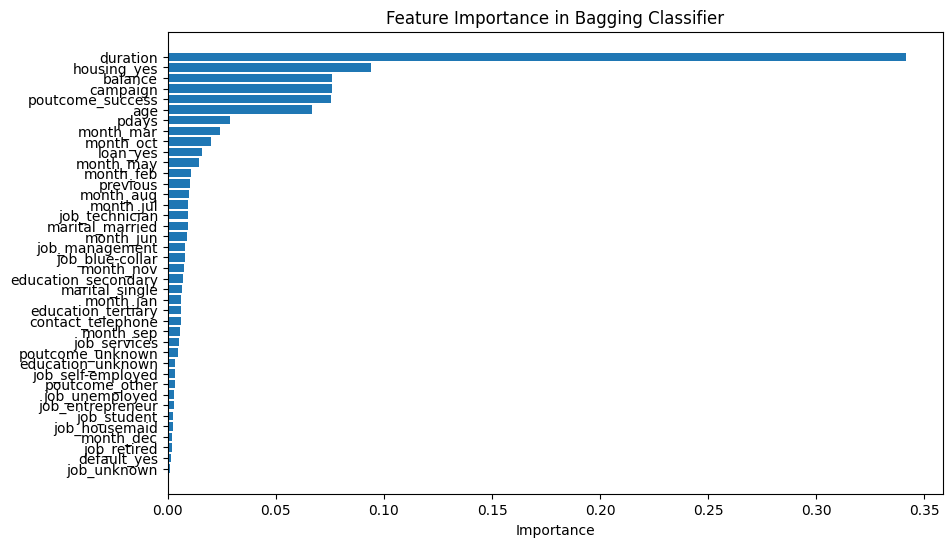

In [80]:
# Initialize a numpy array to accumulate the feature importances
n_features = X_transformed_df.shape[1]  # Number of features
feature_importances = np.zeros(n_features)

# Iterate over all base estimators (decision trees) in the bagging classifier
for tree in best_bagging.estimators_:
    feature_importances += tree.feature_importances_  # Add up the feature importances from each tree

# Take the average across all trees
feature_importances /= len(best_bagging.estimators_)

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_transformed_df.columns,  # Replace with your actual feature names
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Optionally, plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.title('Feature Importance in Bagging Classifier')
plt.xlabel('Importance')
plt.show()
